In [1]:
import h5py
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
import matplotlib.ticker as ticker
import re
import pandas as pd

axisScale = 0.03
datasets = ['organic', 'gm_early', 'gm_late']
colours = ['green', 'blue', 'red']

datasetNo = 0

# define storage arrays and reshape to hold all three galaxy type data
redshifts = np.array(range(3*24), dtype=float)
redshifts.shape = (3, 24)
kco_s = np.array(range(3*24), dtype=float)
kco_s.shape = (3, 24)

# Read data for the redshift->time lookup table
df_o = pd.read_csv('halo_catalogue_organic.txt', delimiter='\t')
df_r2t = df_o[["time [Gyr]"]].copy()
df_r2t = df_r2t.drop(df_r2t.index[range(0,3)])
times = df_r2t.to_numpy()

debug = False

for colour, dataset in enumerate(datasets):
    print('-----------------------------------------')
    print(dataset)
    print('-----------------------------------------')
    
    files = listdir('data/' + dataset)

    count = 0
    
    for file in files:
       
        # get redshift from the filename
        m = re.search('(z[0-9])\w+', file)
        s = m.group(0).replace('z', '')
        s = s.replace('p', '.')
        z = float(s)
        
        print ('z=', z)
        print ('t= %s Gyr' % times[count])
        
        # load data for a particular galaxy at a particular redshift
        f = h5py.File('data/' + dataset + '/' + file,'r')

        # extract data from the file
        ds_c = f['Coordinates']
        ds_v = f['Velocity']
        ds_m = f['Mass']
    
        # Calculate the resultant angular momentum vectors angmom
        # angmom contains the AM vectors for each particle per redshift era
        mv = np.multiply(ds_m, np.transpose(ds_v))
        angMom = np.cross(ds_c, np.transpose(mv))       
        if debug: print ("shape angmom", np.shape(angMom))

        # Calculate the total angular momentum vector by summing the vectors (per redshift epoch)
        angMomTot = np.sum(angMom, axis=0)
        if debug: print ("shape angMomTot", np.shape(angMomTot)) 

        # Calculate the magnitude of the total angular momentum vector for each redshift epoch
        # We use this to normalise the angular momentum to a unit vector for scaling during the transform
        magnitude = np.linalg.norm(angMomTot)

        # Alternative way of calculating the magnitude
        # magnitude2 = np.sqrt(angMomTot[0]**2 + angMomTot[1]**2 + angMomTot[2]**2)

        # Convert the angular momentum vectors to a unit size - the other vectors will be based on this to prevent distortion
        unitVect_z = angMomTot / magnitude
        if debug: print('angMomTot: ', angMomTot)
        if debug: print('magnitude: ', magnitude)
        if debug: print ("unitVect_z", unitVect_z)
        if debug: print ("np.linalg.norm(unitVect_z)", np.linalg.norm(unitVect_z))


        # the angular momentum's vector's (unitVect_z) direction is directly out of the plane of the galaxy
        # unitVect_z = k, but j = [-k2/k1, 1, 0], so

        k = unitVect_z
        if debug: print ("k: ", k)

        j = [-k[1]/k[0], 1, 0]
        j = j/np.linalg.norm(j)
        if debug: print ("j: ", j)

        i = np.cross(j, k)
        i = i/np.linalg.norm(i)
        if debug: print ("i: %s" %  i)
        
        #Orthogonal tests
        if debug:
            test_i_result = np.dot(i,j)
            test_j_result = np.dot(i,k)
            test_k_result = np.dot(j,k)
            if abs(test_i_result) < 1e-5:
                test_i = "Pass"
            else:
                test_i = "FAIL"
            if abs(test_j_result) < 1e-5:
                test_j = "Pass"
            else:
                test_j = "FAIL"
            if abs(test_k_result) < 1e-5:
                test_k = "Pass"
            else:
                test_k = "FAIL"
            print('i.j: %s %s' % (test_i_result, test_i))
            print('i.k: %s %s' % (test_j_result, test_j))
            print('j.k: %s %s' % (test_k_result, test_k))
        
        
        # transform co-ordinates
        dsc_x_trsfrm = np.dot(ds_c, i)       
        dsc_y_trsfrm = np.dot(ds_c, j)      
        dsc_z_trsfrm = np.dot(ds_c, k)
        dsc_trans = np.transpose(np.array([dsc_x_trsfrm, dsc_y_trsfrm, dsc_z_trsfrm]))
        
        #transform velocities
        dsv_x_trsfrm = np.dot(ds_v, i)       
        dsv_y_trsfrm = np.dot(ds_v, j)        
        dsv_z_trsfrm = np.dot(ds_v, k)
        dsv_trans = np.transpose(np.array([dsv_x_trsfrm, dsv_y_trsfrm, dsv_z_trsfrm]))
               
        # Calculate KE of transformed particles
        # Get magnitudes of the vectors
        vel_magnitude = np.linalg.norm(dsv_trans, axis=1)
        if debug: print ('shape vel_magnitude: ', np.shape(vel_magnitude))
        if debug: print ('shape ds_m: ', np.shape(ds_m))
            
        # Calculate kinetic energy for all star particles
        K_tot = np.sum(0.5 * np.array(ds_m) * np.square(vel_magnitude))
        if debug: print ('K_tot: ', K_tot)
        
        # Calculate R, the distance from the centre in the x-y plane
        R = np.sqrt(np.square(dsc_x_trsfrm) + np.square(dsc_y_trsfrm))
               
        # Calculate momentum 
        mv = np.multiply(ds_m, np.transpose(dsv_trans))
        angMom = np.cross(dsc_trans, np.transpose(mv))
        
        # Extract L_z
        L_z = np.array(angMom[:,2])
        
        r0 = 0
        Krot_co = 0
        for n in range(0, len(ds_m)):
            if L_z[n] < 0:
                continue
            if R[n] == 0:
                r0 = r0 + 1
                continue
            Krot_co = Krot_co + (0.5 * ds_m[n] * np.square(L_z[n] / (ds_m[n]*R[n]) ))
        
        print('R=0 count:',r0)
        print('Krot_co:',Krot_co)
        print('Krot_tot:',K_tot)
        
        K_co = Krot_co / K_tot
        print('K_co:',K_co)
        
        redshifts[datasetNo,count] = z
        kco_s[datasetNo,count] = K_co
              
        count = count + 1
        print ('-------------------------------------------------')
        
    # Next galaxy
    datasetNo = datasetNo + 1
    
   

-----------------------------------------
organic
-----------------------------------------
z= 7.05
t= [0.76] Gyr
R=0 count: 0
Krot_co: 5524279878.3322735
Krot_tot: 36702494430.64071
K_co: 0.15051510705278887
-------------------------------------------------
z= 5.971
t= [0.942] Gyr
R=0 count: 0
Krot_co: 37546370059.415985
Krot_tot: 119774170054.30975
K_co: 0.3134763533939844
-------------------------------------------------
z= 5.487
t= [1.049] Gyr
R=0 count: 0
Krot_co: 42588177690.39492
Krot_tot: 160746946946.8226
K_co: 0.2649392632289539
-------------------------------------------------
z= 5.037
t= [1.168] Gyr
R=0 count: 0
Krot_co: 26944582706.502235
Krot_tot: 170171808213.33142
K_co: 0.1583375236438921
-------------------------------------------------
z= 4.485
t= [1.348] Gyr
R=0 count: 0
Krot_co: 77690905306.52808
Krot_tot: 276901259257.15857
K_co: 0.2805725965817166
-------------------------------------------------
z= 3.984
t= [1.556] Gyr
R=0 count: 0
Krot_co: 72713941492.38333
Krot

R=0 count: 0
Krot_co: 1539124043706.0867
Krot_tot: 5656562121601.304
K_co: 0.2720953134817477
-------------------------------------------------
z= 0.615
t= [7.841] Gyr
R=0 count: 1
Krot_co: 4267340699977.1133
Krot_tot: 12161308211293.09
K_co: 0.35089487297217137
-------------------------------------------------
z= 0.503
t= [8.603] Gyr
R=0 count: 0
Krot_co: 6860368606604.737
Krot_tot: 15200896171437.27
K_co: 0.45131343107885186
-------------------------------------------------
z= 0.366
t= [9.698] Gyr
R=0 count: 1
Krot_co: 8072787732864.815
Krot_tot: 18831936036446.086
K_co: 0.4286754010443363
-------------------------------------------------
z= 0.271
t= [10.577] Gyr
R=0 count: 1
Krot_co: 9638804413452.809
Krot_tot: 20599576889648.26
K_co: 0.46791273748425966
-------------------------------------------------
z= 0.183
t= [11.501] Gyr
R=0 count: 1
Krot_co: 9890304161701.756
Krot_tot: 20523756605165.45
K_co: 0.4818954128121238
-------------------------------------------------
z= 0.101
t= [1

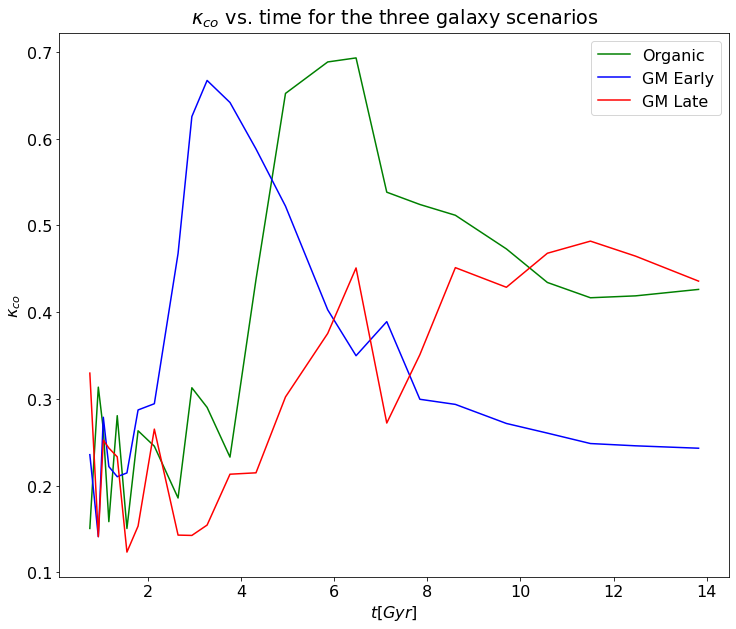

In [11]:
plt.figure(figsize = (12,10))
plt.title('$\kappa_{co}$ vs. time for the three galaxy scenarios', pad=10)
plt.xlabel('$t [Gyr]$')
plt.ylabel('$\kappa_{co}$')

for i in range(0,3):
    plt.rcParams['font.size'] = '16'
    plt.plot(times, kco_s[i,0:], color=colours[i])

plt.legend(['Organic', 'GM Early', 'GM Late'])

#plt.xlim(0.3, 20)

plt.show()   